In [421]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aicc

# This implementetion follows the methodology of https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [422]:
#load data
df = pd.read_csv('final.csv', parse_dates=['Month'], index_col='Month')
print(df.shape)  # (294, 6)
df.tail()

(294, 6)


,coal_price,crude_price,ngas_price,gold_price,iron_price,aud_usd_closed
Month,,,,,,
2019-09-01,65.95,62.33,2.58,1510.58,93.08,0.6750
2019-10-01,69.20,59.37,2.33,1494.81,88.53,0.6894
2019-11-01,66.99,62.74,2.65,1470.79,84.98,0.6765
2019-12-01,66.18,65.85,2.24,1479.13,92.65,0.7022
2020-01-01,69.66,63.60,2.02,1560.67,95.76,0.6692


In [427]:
# grangers casuality test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,coal_price_x,crude_price_x,ngas_price_x,gold_price_x,iron_price_x,aud_usd_closed_x
coal_price_y,1.0000,0.0514,0.0175,0.0003,0.0048,0.0000
crude_price_y,0.0075,1.0000,0.5577,0.0153,0.0000,0.0000
ngas_price_y,0.1811,0.0013,1.0000,0.0875,0.0049,0.1501
gold_price_y,0.0000,0.0207,0.1853,1.0000,0.0176,0.0019
iron_price_y,0.0016,0.0096,0.0517,0.0015,1.0000,0.0000
aud_usd_closed_y,0.0272,0.0051,0.4427,0.0077,0.0359,1.0000


In [429]:
# foracasting months
nobs = 60
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (224, 6)
print(df_test.shape)  # (60, 6)

(284, 6)
(10, 6)


In [430]:
#build the adfuller test
def ADF_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [431]:
# ADF Test
for name, column in df_train.iteritems():
    ADF_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "coal_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2434
 No. Lags Chosen       = 8
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.6546. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "crude_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0903
 No. Lags Chosen       = 1
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.2484. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ngas_price" 
    -----------------------------------------------
 Null Hypothesi

In [432]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [433]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "coal_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.2433
 No. Lags Chosen       = 7
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "crude_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.2415
 No. Lags Chosen       = 0
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ngas_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significa

In [434]:
# AIC test 
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)


Lag Order = 1
AIC :  -11.984892786282739
Lag Order = 2
AIC :  -11.987511145018754
Lag Order = 3
AIC :  -11.914340940437963
Lag Order = 4
AIC :  -11.818476068905916
Lag Order = 5
AIC :  -11.742464386496415
Lag Order = 6
AIC :  -11.702576973767373
Lag Order = 7
AIC :  -11.632165929060474
Lag Order = 8
AIC :  -11.601731222149292
Lag Order = 9
AIC :  -11.50163384313884
Lag Order = 10
AIC :  -11.409354758515219


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [435]:
# Order selection with select_order
x = model.select_order(maxlags=10)
x.summary()

,AIC,BIC,FPE,HQIC
0,-11.61,-11.53*,9.110e-06,-11.57
1,-11.91,-11.35,6.754e-06,-11.68*
2,-11.93*,-10.89,6.624e-06*,-11.51
3,-11.87,-10.36,7.020e-06,-11.26
4,-11.78,-9.793,7.711e-06,-10.98
5,-11.72,-9.262,8.165e-06,-10.73
6,-11.66,-8.729,8.686e-06,-10.49
7,-11.58,-8.164,9.546e-06,-10.21
8,-11.56,-7.676,9.737e-06,-10.00
9,-11.48,-7.113,1.073e-05,-9.725


In [436]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 09, Dec, 2020
Time:                     18:35:13
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -10.9776
Nobs:                     281.000    HQIC:                  -11.5825
Log likelihood:          -630.085    FPE:                6.22390e-06
AIC:                     -11.9875    Det(Omega_mle):     4.74478e-06
--------------------------------------------------------------------
Results for equation coal_price
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.001570         0.003667            0.428           0.669
L1.coal_price             0.201340         0.063428            3.174           0.002
L1.crude_price            0.000289     

In [437]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

coal_price : 2.01
crude_price : 2.03
ngas_price : 2.0
gold_price : 2.0
iron_price : 2.01
aud_usd_closed : 1.97


In [438]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

2


array([[-3.23772997e-02,  4.86000000e+00, -1.24297717e-01,
         2.83200000e+01,  1.46997304e-01, -1.78000000e-02],
       [-2.43992161e-02,  2.28000000e+00,  7.77777010e-02,
        -1.91700000e+01, -2.00361617e-02,  2.00000000e-04]])

In [439]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_d')
df_forecast

,coal_price_d,crude_price_d,ngas_price_d,gold_price_d,iron_price_d,aud_usd_closed_d
Month,,,,,,
2019-04-01,-0.010142,0.464068,0.045395,4.444215,-0.034227,0.008553
2019-05-01,-0.002206,-0.213351,0.016919,5.752312,0.010867,-0.001101
2019-06-01,0.004505,-0.140472,-0.000939,3.643170,0.015609,0.001076
2019-07-01,0.003281,0.257019,-0.000167,4.259144,0.006029,0.000155
2019-08-01,0.003401,0.324995,0.000119,3.545311,0.002226,-0.000620
2019-09-01,0.002782,0.192465,0.001777,3.148545,0.002812,-0.000005
2019-10-01,0.002851,0.163076,0.002897,3.207767,0.003936,-0.000017
2019-11-01,0.003022,0.175381,0.002154,3.304956,0.004263,-0.000154
2019-12-01,0.002917,0.181726,0.001886,3.291892,0.004011,-0.000168


In [440]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_d'].cumsum()
    return df_fc

In [441]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results.loc[:, ['coal_price_forecast', 'crude_price_forecast', 'ngas_price_forecast', 'gold_price_forecast',
                   'iron_price_forecast', 'aud_usd_closed_forecast']]

,coal_price_forecast,crude_price_forecast,ngas_price_forecast,gold_price_forecast,iron_price_forecast,aud_usd_closed_forecast
Month,,,,,,
2019-04-01,4.523747,66.874068,1.123805,1305.344215,4.425570,0.718253
2019-05-01,4.521541,66.660717,1.140724,1311.096527,4.436438,0.717152
2019-06-01,4.526046,66.520245,1.139785,1314.739697,4.452047,0.718228
2019-07-01,4.529327,66.777264,1.139618,1318.998841,4.458076,0.718383
2019-08-01,4.532728,67.102259,1.139737,1322.544153,4.460302,0.717763
2019-09-01,4.535510,67.294724,1.141514,1325.692697,4.463115,0.717758
2019-10-01,4.538361,67.457800,1.144412,1328.900464,4.467051,0.717741
2019-11-01,4.541383,67.633181,1.146566,1332.205421,4.471314,0.717587
2019-12-01,4.544300,67.814908,1.148452,1335.497312,4.475325,0.717418


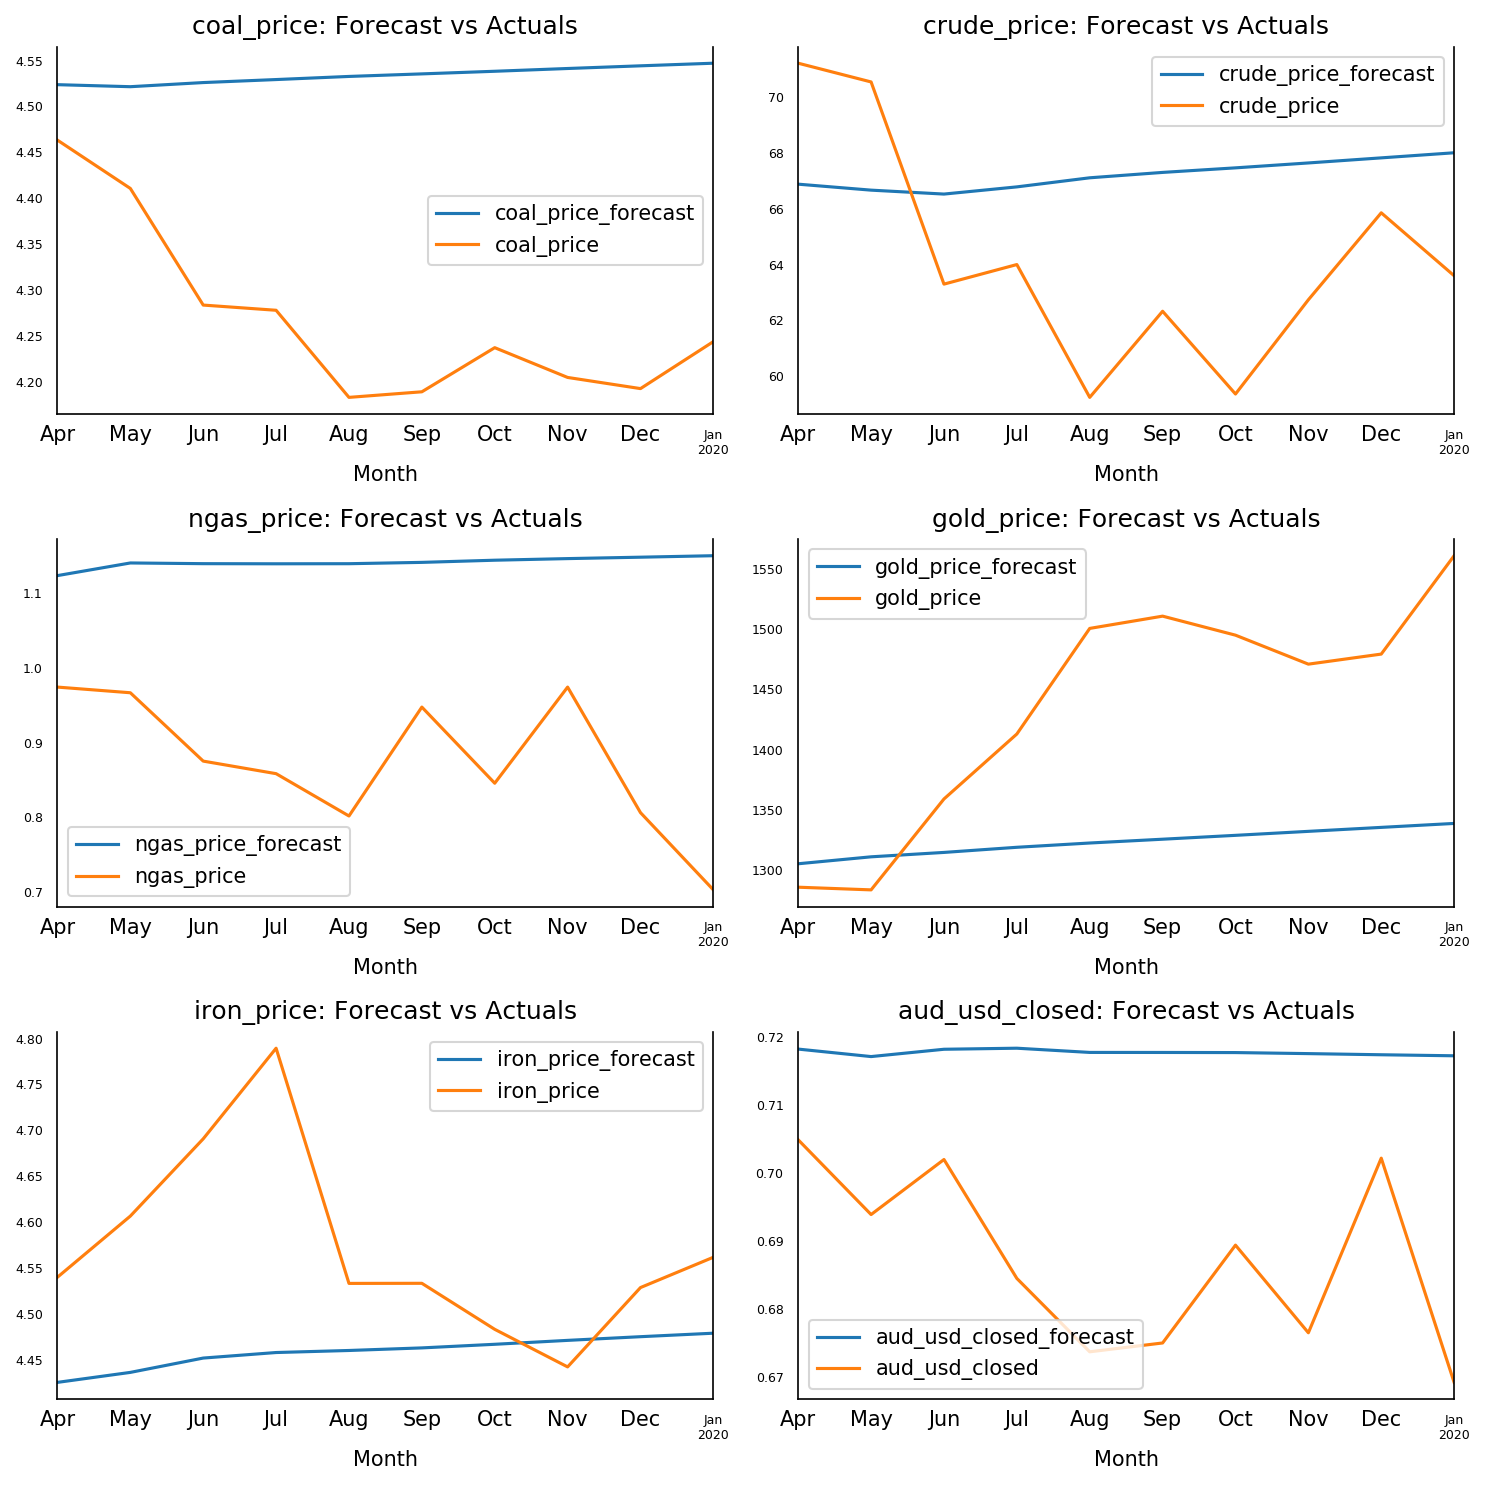

In [442]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [444]:
#evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error    


rmse = np.sqrt(mean_squared_error(df_test['aud_usd_closed'],df_results['aud_usd_closed_forecast'].values))
print('Root Mean Square Error value of the VAR Model is:', (1-rmse)*100)

mape = np.mean(np.abs((df_test['aud_usd_closed']-df_results['aud_usd_closed_forecast'].values)/df_test['aud_usd_closed']))*100
print('Mean Absolute Percentage Error value of the VAR Model is:', (mape))

mpe = np.mean(df_test['aud_usd_closed']-df_results['aud_usd_closed_forecast'].values)
print('Mean percentage Error value of the VAR Model is:', (mpe))

Root Mean Square Error value of the VAR Model is: 93.38682802068084
Mean Absolute Percentage Error value of the VAR Model is: 13.474870996473
Mean percentage Error value of the VAR Model is: -3.062496537218274
